# Modelo DNN

In [1]:
import pandas as pd
import numpy as np
import torch, time
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn import metrics
import os

In [2]:
# Carga dataset desde la carpeta raíz generada por TINTOlib
ruta_carpeta_actual = os.getcwd()
ruta_carpeta_raiz = os.path.dirname(ruta_carpeta_actual)
csv_path  = os.path.join(ruta_carpeta_raiz, "dataset", "PuntosMuestra_CR_2023.csv")
df = pd.read_csv(csv_path)

## Limpieza

In [3]:
# Quitar valores de la CATEGORIA = 2
df_filtrado = df[df["CATEGORIA"] != 2].copy()

# Re-mapear las clases a valores consecutivos desde 0
clases_unicas = sorted(df_filtrado["CATEGORIA"].unique())
mapa = {old: new for new, old in enumerate(clases_unicas)}
df_filtrado["CATEGORIA"] = df_filtrado["CATEGORIA"].map(mapa)

y = df_filtrado["CATEGORIA"]
X = df_filtrado.drop(columns=["CATEGORIA","lon","lat","year"])

## Preprocesamiento

In [4]:
# Estandarizar características (mejora el entrenamiento de redes)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Data de entrenamiento y prueba

In [5]:
# --------------------------
# 2. Split train/test
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# Convertir a tensores
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.long)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values, dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl  = DataLoader(test_ds, batch_size=128)

## Definir modelo entrenamiento

In [6]:
# --------------------------
# 3. Definir modelo MLP
# --------------------------
input_dim = X_train.shape[1]
num_classes = len(y.unique())

class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim, num_classes).to(device)

crit = nn.CrossEntropyLoss()
opt  = torch.optim.Adam(model.parameters(), lr=1e-3)

## Entrenamiento y testeo

In [7]:
# 4. Entrenamiento
epochs = 20
t0 = time.perf_counter()
for ep in range(epochs):
    model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = crit(model(xb), yb)
        loss.backward()
        opt.step()
fit_s = time.perf_counter() - t0
print(f"⏱ Entrenamiento ({epochs} ep): {fit_s:.2f}s")

# 5. Test
t0 = time.perf_counter()
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu().tolist()
        y_pred += preds
        y_true += yb.tolist()
pred_s = time.perf_counter() - t0
ms_per_sample = (pred_s/len(y_true))*1000
print(f"⏱ Test: {pred_s:.3f}s  ({ms_per_sample:.2f} ms/muestra)")

⏱ Entrenamiento (20 ep): 6.39s
⏱ Test: 0.040s  (0.00 ms/muestra)


### Matriz de confusion

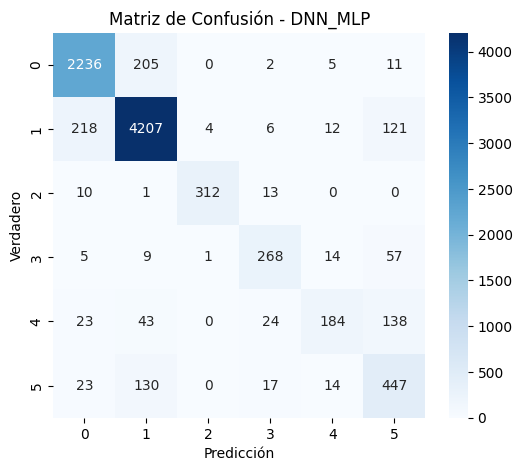

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- calcular matriz de confusión con los últimos resultados ---
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión - DNN_MLP")
plt.show()

## Resultados

In [8]:
oa  = accuracy_score(y_true, y_pred)
f1m = f1_score(y_true, y_pred, average="macro")
cm  = confusion_matrix(y_true, y_pred)

print(f"OA={oa:.4f} | F1-macro={f1m:.4f}")
print("Matriz de confusión:\n", cm)

OA=0.8737 | F1-macro=0.7945
Matriz de confusión:
 [[2236  205    0    2    5   11]
 [ 218 4207    4    6   12  121]
 [  10    1  312   13    0    0]
 [   5    9    1  268   14   57]
 [  23   43    0   24  184  138]
 [  23  130    0   17   14  447]]


# Registrar informacion

In [9]:
import sys
sys.path.append("..")
import importlib, utils_log
importlib.reload(utils_log)
from utils_log import log_row

carpeta_actual = ruta_carpeta_actual.split("\\")[-1]
dataset_utilizado = csv_path.split("\\")[-1]

log_row(
  script="20250901_PruebasEntrenamientoDNN.ipynb",
  algoritmo="DNN_MLP",
  dataset=dataset_utilizado,
  clases_removidas=[2],
  seed=42,
  n_train=len(y_true), n_test=len(y_pred),
  n_features=X.shape[1], num_classes=len(sorted(y.unique())),
  fit_seconds=fit_s, pred_seconds=pred_s,
  ms_per_sample=(pred_s/len(y_pred))*1000,
  OA=oa, F1_macro=f1m,
  carpeta=carpeta_actual
)

c:\Users\Fran\anaconda3\envs\tintoenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
